# Senatorial Clustering
by Brad Gasdia


# Executive Summary
In Robert Caro's book The Master of the Senate, he describes Lyndon B. Johnson's exceptional ability to predict the voting habits of his fellow senators. 
Because some senators are secretive of their intents in future votes, what we have to rely on then is their previous votes, coupled with the expressed intentions of their constituents.

In [1]:
# packages for data procesing
import pandas as pd
from numpy import where

# sklearn packages for decomposition and clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# import packages for web scraping
from bs4 import BeautifulSoup
import requests

#viz
import matplotlib.pyplot as plt

In [528]:
congress = 101
session = 1
url = f'https://www.senate.gov/legislative/LIS/roll_call_lists/vote_menu_{congress}_{session}.htm'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

In [529]:
# find table with id of 'listOfVotes_info'
table = soup.find('table', id='listOfVotes')
table = table.prettify()

import re

# get urls from scraped link. Each URL we will use contains votes
urls = re.findall(r'href=[\'"]?([^\'" >]+)', table)
urls = [url for url in urls if 'roll_call_votes' in url]

In [530]:
votes = []

# for loop, scraping each page
for url in urls:
    vote_url = 'https://www.senate.gov{vote}'.format(vote=url)

    page = requests.get(vote_url)
    soup = BeautifulSoup(page.content, 'html.parser')

        # get div with class newspaperDisplay_3column
    div = soup.find('div', class_='newspaperDisplay_3column')
    vote_det = div.prettify().split('\n  </b>')
    voter = [i.split('\n')[2] for i in vote_det]
    casted = [i.split('\n')[4] for i in vote_det]
    id_vote = [url.split('/')[-1].split('.')[0]] * len(voter)

    votes.append([voter, casted, id_vote])

df = pd.concat([pd.DataFrame(votes[i]).T for i in range(len(votes))])
df.columns=['Senator', 'Cast', 'Vote']
df = df[df['Cast']!='']
df['Cast'] = df['Cast'].str.strip()

In [531]:
df

,Senator,Cast,Vote
0,"Adams (D-WA),",Yea,vote_101_1_00312
1,"Armstrong (R-CO),",Yea,vote_101_1_00312
2,"Baucus (D-MT),",Yea,vote_101_1_00312
3,"Bentsen (D-TX),",Yea,vote_101_1_00312
4,"Biden (D-DE),",Yea,vote_101_1_00312
...,...,...,...
95,"Thurmond (R-SC),",Yea,vote_101_1_00001
96,"Wallop (R-WY),",Yea,vote_101_1_00001
97,"Warner (R-VA),",Yea,vote_101_1_00001
98,"Wilson (R-CA),",Yea,vote_101_1_00001


We now have a dtaframe of senators and their votes. I'm going to ignore impeachment votes temporarily. A few methods as I cluster

1. Yea as 1, nay as -1, and abstain as 0
2. Yea as 1, nay as -1, and imputate Present

In [532]:
df['cast_recode'] = where(df['Cast'].str.contains('Yea'), 1, df.Cast)
df['cast_recode'] = where(df['Cast'].str.contains('Guilty'), 1, df.cast_recode)
df['cast_recode'] = where(df['Cast'].str.contains('Nay'), 0, df.cast_recode)
df['cast_recode'] = where(df['Cast'].str.contains('Not Guilty'), 0, df.cast_recode)
# if not voting or present, then 0
df['cast_recode'] = where(df['Cast'].str.contains('Not Voting|Present, Giving Live Pair'), 0, df.cast_recode)
df['cast_recode'] = where(df['Cast'] == 'Present', 0, df.cast_recode)
df['cast_recode'] = df['cast_recode'].astype(int)

In [533]:
df_pivot = df.pivot(index='Senator', columns='Vote', values='cast_recode').reset_index()
# group senators by max vote number, and drop 0's
drop_id = df_pivot[df_pivot.columns[2:]].abs().sum(axis=1).where(df_pivot[df_pivot.columns[2:]].abs().sum(axis=1)<50).dropna().index

# get records of senators who voted
df_pivot = df_pivot.drop(drop_id, axis=0)

df_pivot.reset_index(inplace=True, drop=True)

In [569]:
# flatten the dataframe
X = df_pivot.drop(['Senator'], axis=1).values.astype(int)
X_transform = PCA().fit_transform(X)

In [570]:
from matplotlib.colors import ListedColormap

colors = ['red', 'blue', 'green']
cmap = ListedColormap(colors)

# map R to 0, D to 1, I to 2
party = [i.split('(')[-1][0] for i in df_pivot.Senator]
party = [0 if i == 'R' else 1 if i == 'D' else 2 for i in party]

<ipython-input-571-3901650370b8>:18: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



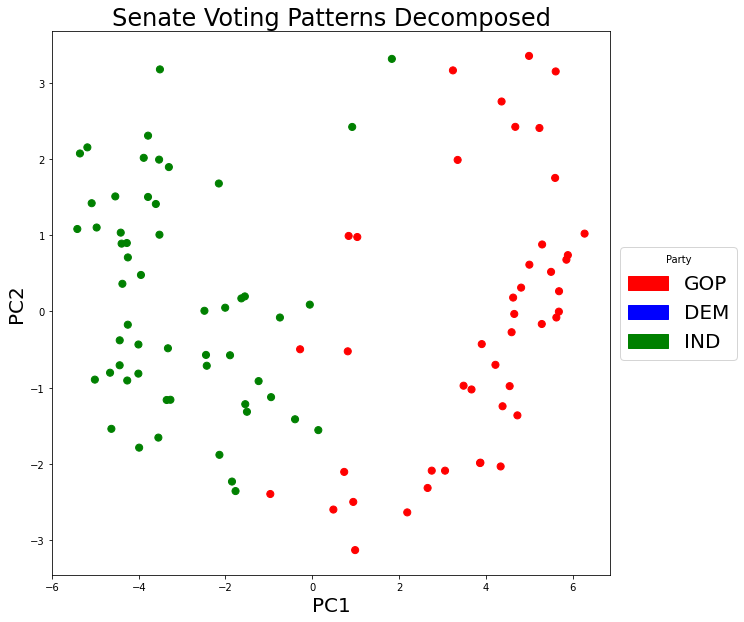

In [571]:
size_title = 24
size_label = 20

plt.figure(figsize=(10,10))
plt.title('Senate Voting Patterns Decomposed', fontsize=size_title)

# map party colors, R = 1, D = 2, I = 3
# make R red, d blue, i green
plt.scatter(X_transform[:, 0], X_transform[:, 1], c=party, cmap=cmap, s=50)
plt.xlabel('PC1', fontsize=size_label)
plt.ylabel('PC2', fontsize=size_label)

# add legend
import matplotlib.patches as mpatches

legend_elements = [mpatches.Patch(color='red'), mpatches.Patch(color='blue'), mpatches.Patch(color='green')]

ax = plt.subplot()

ax.legend(legend_elements, ['GOP', 'DEM', 'IND'], fontsize=size_label, 
            loc='center left', bbox_to_anchor=(1, .5), title='Party')

plt.show()

In [540]:
# cluster
kmeans = KMeans(n_clusters=4, random_state=0).fit(X_transform)
df_pivot['cluster'] = kmeans.labels_

In [542]:
# import plotly
import plotly.express as px

# plot the above, with an interactive legend
fig = px.scatter_3d(df_pivot, x=X_transform[:, 0], y=X_transform[:, 1], z=X_transform[:, 2],
                    color = kmeans.labels_,
                    
                    hover_name='Senator'
)

# plot
fig.show()